In [1]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from scipy.interpolate import UnivariateSpline
# from scipy import stats
import pickle

from itertools import chain
from scipy.optimize import curve_fit

# Import ART

sys.path.append('.')
sys.path.append('../ART_iGEM')

from art.core import *
import art.plot as plot

Do not have mpi4py package.
Do not have acor package


# The first step: Loading and structuring the data

The Automated Recommendation tool is used to determine which combination of *Saccharomyces spp.* strain, promotor, secretion peptide and alpha-amylase gene is expected to yield a high alpha-amylase activity. The training data for ART consists of alpha-amylase activity produced by **X** samples out of the possible 640 combinations. This activity was measured using the **X** kit. 



However, the first step is to load in the various data files and restructure them.

In [4]:
# Storing the current working directory for later usage
cwd = os.getcwd()

# Change into the correct working directory
data_dir = os.path.join(cwd,'data','AA 2-10')
os.chdir(data_dir)

In [5]:
# Extract the file names of all absorbance measurement files
abs_files = glob.glob('*.TXT')
print(abs_files)
abs_files.remove('error_2111.TXT') # One of the measurements was incorrectly excecuted. This file has to manually exlcuded from the analysis
abs_files.sort()
print(abs_files)

# Creating a dataframe with time measurements and reference to the absorbance measure file
abs_df = pd.DataFrame(columns=['Hour', 'Minute', 'absolute_diff', 'File_name', 'abs_measurements'])
for i, file in enumerate(abs_files):
    ms_time = file.split('.')
    ms_time = [int(string) for string in ms_time[0:2]]
    if i == 0:
        time_diff = 0
    else:
        time_diff = (ms_time[0]-abs_df['Hour'][0])*60+(ms_time[1]-abs_df['Minute'][0])
    abs_measurement = pd.read_csv(file, header = None, sep=',')
    abs_measurement = abs_measurement.iloc[:, :-1] # Due to the output format of the plate reader, there is an extra column with empty values.
    abs_df.loc[i] = [ms_time[0], ms_time[1], time_diff, file, abs_measurement]
    print(np.shape(abs_df['abs_measurements'][i]))
print(abs_df)

['19.44.TXT', '19.34.TXT', '20.04.TXT', '20.14.TXT', '19.14.TXT', '19.02.TXT', '19.29.TXT', 'error_2111.TXT', '19.24.TXT', '20.09.TXT', '19.59.TXT', '19.54.TXT', '19.19.TXT', '21.12.TXT', '19.49.TXT', '19.39.TXT']
['19.02.TXT', '19.14.TXT', '19.19.TXT', '19.24.TXT', '19.29.TXT', '19.34.TXT', '19.39.TXT', '19.44.TXT', '19.49.TXT', '19.54.TXT', '19.59.TXT', '20.04.TXT', '20.09.TXT', '20.14.TXT', '21.12.TXT']
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
   Hour Minute absolute_diff  File_name  \
0    19      2             0  19.02.TXT   
1    19     14            12  19.14.TXT   
2    19     19            17  19.19.TXT   
3    19     24            22  19.24.TXT   
4    19     29            27  19.29.TXT   
5    19     34            32  19.34.TXT   
6    19     39            37  19.39.TXT   
7    19     44            42  19.44.TXT   
8    19     49            47  19.49.TXT   
9    19     54            52  19.54.TXT 

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [6]:
# Next up, is getting the locations of the plates for each sample
plate_arr = pd.read_csv('plate_arrangements.csv', sep=',')
plate_arr = plate_arr.iloc[:, 1:] # For easy navigation, the first column is removed
plate_arr.columns = [int(col_num)-1 for col_num in plate_arr.columns]

# The dataframe of the well locations is now in exactly the same shape as the dataframes used for storing the absorbance measures
print(np.shape(plate_arr))

print(plate_arr)
print(abs_df['abs_measurements'][0])


(8, 12)
    0    1      2      3      4      5       6       7    8    9    10   11
0  NaN  NaN    NaN    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
1  NaN  NaN    NaN    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
2  NaN  NaN  BLANK  BLANK  2nmol  2nmol  10nmol  10nmol  #34  NaN  NaN  NaN
3  #14  #14    #14    #15    #15    #15     #18     #18  #18  #20  #20  #20
4  #26  #26    #26    #27    #27    #27     #34     #34  NaN  #35  #35  #35
5  NaN  NaN    NaN    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
6  #06  #06    #06    #10    #10    #10     #11     #11  #11  #16  #16  #16
7  #21  #21    #21    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
      0      1      2      3      4      5      6      7      8      9   \
0  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  0.000  0.000  0.056  0.055  0.145  0.152  0.481  0.503  0.067  0.000   
3  0.066

In [7]:
# Extracting the unique values out of the plate arragements
samples = plate_arr.values.flatten()
samples = np.unique(samples.astype(str)) 
samples = np.delete(samples, np.where(samples == 'nan'))
print(f'Total number of unique samples in dataset: {len(samples)-3}')
# After extracting the unique values, it is possible to create a disctionary where each sample is matched with the corresponding absorbance measure
sample_dict = {}
for sample in samples:
    coordinates = np.array(np.where(plate_arr == sample)).T
    for i, coord in enumerate(coordinates):
        sample_name = sample + '_r' + str(i)
        sample_dict[sample_name] = [measurement[coord[1]][coord[0]] for measurement in abs_df['abs_measurements']]
print(sample_dict)

Total number of unique samples in dataset: 13
{'#06_r0': [0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065], '#06_r1': [0.067, 0.072, 0.075, 0.078, 0.08, 0.083, 0.085, 0.088, 0.09, 0.093, 0.095, 0.098, 0.101, 0.104, 0.133], '#06_r2': [0.065, 0.064, 0.064, 0.065, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.065], '#10_r0': [0.07, 0.079, 0.084, 0.089, 0.093, 0.099, 0.105, 0.11, 0.116, 0.122, 0.127, 0.133, 0.139, 0.147, 0.214], '#10_r1': [0.068, 0.077, 0.082, 0.087, 0.092, 0.097, 0.103, 0.108, 0.114, 0.12, 0.126, 0.132, 0.138, 0.145, 0.213], '#10_r2': [0.088, 0.085, 0.087, 0.09, 0.093, 0.098, 0.103, 0.108, 0.114, 0.12, 0.126, 0.131, 0.137, 0.145, 0.214], '#11_r0': [0.066, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.068], '#11_r1': [0.067, 0.075, 0.078, 0.082, 0.085, 0.089, 0.092, 0.096, 0.099, 0.102, 0.106, 0.109, 0.112, 0.117, 0.154], '#11_r2': [0.066, 0.066,

In [8]:
# The final dataframe that needs to be loaded are the OD measures for each sample

OD_measures = pd.read_csv('OD_standerdized.csv', sep=',')
print(OD_measures)


   sample  Dilution(%)  OD (raw)  OD (stadardized)
0      14          2.5     0.136             0.072
1      15          2.5     0.118             0.054
2      18          2.5     0.131             0.067
3      20          2.5     0.134             0.070
4      26          2.5     0.130             0.066
5      27          2.5     0.117             0.053
6      34          2.5     0.132             0.068
7      35          2.5     0.142             0.078
8       6          2.5     0.136             0.072
9      10          2.5     0.123             0.059
10     11          2.5     0.139             0.075
11     16          2.5     0.106             0.042
12     21          2.5     0.164             0.100
13      B          2.5     0.064             0.000


# Step 2: Filtering and correcting the data for the baseline absorbance

The data currently stored in sample_dict cannot be used yet. The following data preprocessing steps need to be taken first:

1. Subtract the baseline absorbance
2. Remove any values above the 10nmol standard. 

In [9]:
# Determining the average baseline
baseline = np.average([sample_dict['BLANK_r0'],sample_dict['BLANK_r1']], axis=0)

# subtracting the baseline from the other samples
for sample in sample_dict:
    sample_dict[sample] = np.subtract(sample_dict[sample], baseline)

print(sample_dict)

{'#06_r0': array([0.0095, 0.009 , 0.009 , 0.009 , 0.009 , 0.009 , 0.009 , 0.009 ,
       0.009 , 0.009 , 0.009 , 0.009 , 0.009 , 0.009 , 0.009 ]), '#06_r1': array([0.0115, 0.016 , 0.019 , 0.022 , 0.024 , 0.027 , 0.029 , 0.032 ,
       0.034 , 0.037 , 0.039 , 0.042 , 0.045 , 0.048 , 0.077 ]), '#06_r2': array([0.0095, 0.008 , 0.008 , 0.009 , 0.008 , 0.008 , 0.008 , 0.008 ,
       0.008 , 0.008 , 0.008 , 0.008 , 0.008 , 0.008 , 0.009 ]), '#10_r0': array([0.0145, 0.023 , 0.028 , 0.033 , 0.037 , 0.043 , 0.049 , 0.054 ,
       0.06  , 0.066 , 0.071 , 0.077 , 0.083 , 0.091 , 0.158 ]), '#10_r1': array([0.0125, 0.021 , 0.026 , 0.031 , 0.036 , 0.041 , 0.047 , 0.052 ,
       0.058 , 0.064 , 0.07  , 0.076 , 0.082 , 0.089 , 0.157 ]), '#10_r2': array([0.0325, 0.029 , 0.031 , 0.034 , 0.037 , 0.042 , 0.047 , 0.052 ,
       0.058 , 0.064 , 0.07  , 0.075 , 0.081 , 0.089 , 0.158 ]), '#11_r0': array([0.0105, 0.011 , 0.011 , 0.011 , 0.011 , 0.011 , 0.011 , 0.011 ,
       0.011 , 0.011 , 0.011 , 0.011 , 0.0

In [10]:
# Next up is checking whether there are any datapoints that show an obsorbance which is higher than the 10nmol 
# standard. Measurements above this standard are not reliable and thus cannot be used as input for the ART. 
# Measurements of the same sample taken before the sample exceeded the standard can still be used as training data 
# for the ART.

def correct_sample_by_standard(standard, sample, sample_name):
    rest = np.subtract(standard, sample)
    corrected_sample = sample
    for i, d_measurement in enumerate(rest):
        if d_measurement < 0:
            corrected_sample = sample[:i]
            print(f'Shortening the time series of sample {sample_name} to length {len(corrected_sample)}')
            break
    return corrected_sample

avg_10nmol_standard = np.average([sample_dict['10nmol_r0'],sample_dict['10nmol_r1']], axis=0)

for sample, measurement in sample_dict.items():
    if ('#' in sample): # Only check the actual samples and skip the standard and baseline measurements
        sample_dict[sample] = correct_sample_by_standard(avg_10nmol_standard, measurement, sample)


Shortening the time series of sample #20_r1 to length 6


# Step 3: Determine alpha-amylase activity of each sample

The alpha-amylase activity of a sample is determined y the change in absorbance over time. This change in absorbance 
is linear with respect to time. Therefore, it is possible to fit a linear curve to each sample in order to abtain a function in the form of $absorbance = a*t+b$, where $a$ is the change in absorbance over time (i.e. the alpha-amylase activity), $t$ is the time and $b$ is some offset. 

Under perfect conditions, $b$ would be 0. However, preparing the samples takes some time. This means that at the time of the first measurement, some samples already had the time to **X** for about 15 minutes while others were only prepared one minute in advance. This means that $b$ will not be 0 for most of our samples.

For our analysis, the exact value of $b$ is irrelevant as the main interest lies within the change in absobance (i.e. $a$). The value of $b$ is only needed in order to fit the linear curve better to the datapoints. Once the curve has been fitted, the $a$ value is used and interpreted as the alpha-amylase activity of the sample. 

The ydata of sample #06_r0: [0.0095 0.009  0.009  0.009  0.009  0.009  0.009  0.009  0.009  0.009
 0.009  0.009  0.009  0.009  0.009 ]
Sample #06_r1 fits the linear curve with an R^2 of 0.9991643891211567
The ydata of sample #06_r2: [0.0095 0.008  0.008  0.009  0.008  0.008  0.008  0.008  0.008  0.008
 0.008  0.008  0.008  0.008  0.009 ]
Sample #10_r0 fits the linear curve with an R^2 of 0.9961603991092894
Sample #10_r1 fits the linear curve with an R^2 of 0.9963388616499251
Sample #10_r2 fits the linear curve with an R^2 of 0.9608470498519187
The ydata of sample #11_r0: [0.0105 0.011  0.011  0.011  0.011  0.011  0.011  0.011  0.011  0.011
 0.011  0.011  0.011  0.011  0.012 ]
Sample #11_r1 fits the linear curve with an R^2 of 0.9994143522228782
The ydata of sample #11_r2: [0.0105 0.01   0.011  0.011  0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.011 ]
The ydata of sample #14_r0: [0.0105 0.009  0.009  0.009  0.009  0.009  0.009  0.009  0.009  0.009
 0.009  0.009

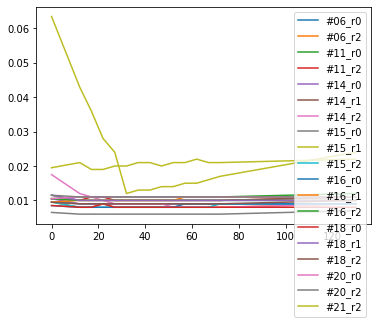

In [11]:

# Defining a linear curve
def linear_curve(x, a, b):
    return a * x + b

# Calculating R^2. For an explanation, see https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def determine_R2(xdata, ydata, popt):
    residuals = ydata - linear_curve(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

activity_dict={}
for sample in sample_dict:
    if ('#' in sample): # Only analize the samples and not the standards
        ydata = sample_dict[sample]
        xdata = abs_df['absolute_diff'][:len(ydata)] # As some samples might have been corrected for exceeding the standard, the length of the xdata might need to be shortened as well for that perticular sample
        popt, pcov = curve_fit(linear_curve, xdata, ydata)
        a, b = popt
        activity_dict[sample] = a # As explaine above, the slope of the curve is anagolous to the activity of the sample
        R_squared = determine_R2(xdata, ydata, popt)

        # The R^2 value represents how well the y-value can be explained by the x-value by some function f(). In this case,
        # the f() function is a first order polynomial (i.e. a linear curve) in the form of f(x)=y=a*x+b. The downside of using 
        # the R^2 value for representing the fit to a linear curve, is that is there is no slope (i.e. a=0), the R^2 value is 0
        # as well. Therefore, all absorbance measures that have a R^2 value of less than 0.95 need to be manually verified on whether
        # they are in fact linear curves. 
        if R_squared < 0.95: 
            plt.plot(xdata, ydata, label=sample)
            #print(f'R^2 value of sample {sample}: {R_squared}')
            print(f'The ydata of sample {sample}: {ydata}')
        else:
            print(f'Sample {sample} fits the linear curve with an R^2 of {R_squared}')
plt.legend()

Based on the figure created in the cell above, it should be possible to locate any sample that does not show the expected linear behavior. In order to exclude this sample, along with other replicates of the same sample, enter the name of this sample in the in the cell below

In [12]:

samples_to_exclude = [] # for example: ['#26', '#17'] in order to exclude all replicates of samples 26 and 17


print(f'Samples in dictionary before removal: {activity_dict.keys()}')
for sample in samples_to_exclude:
    activity_dict = dict(filter(lambda elem: sample not in elem[0], activity_dict.items()))
print(f'Samples in dictionary after removal: {activity_dict.keys()}')

Samples in dictionary before removal: dict_keys(['#06_r0', '#06_r1', '#06_r2', '#10_r0', '#10_r1', '#10_r2', '#11_r0', '#11_r1', '#11_r2', '#14_r0', '#14_r1', '#14_r2', '#15_r0', '#15_r1', '#15_r2', '#16_r0', '#16_r1', '#16_r2', '#18_r0', '#18_r1', '#18_r2', '#20_r0', '#20_r1', '#20_r2', '#21_r0', '#21_r1', '#21_r2', '#26_r0', '#26_r1', '#26_r2', '#27_r0', '#27_r1', '#27_r2', '#34_r0', '#34_r1', '#34_r2', '#35_r0', '#35_r1', '#35_r2'])
Samples in dictionary after removal: dict_keys(['#06_r0', '#06_r1', '#06_r2', '#10_r0', '#10_r1', '#10_r2', '#11_r0', '#11_r1', '#11_r2', '#14_r0', '#14_r1', '#14_r2', '#15_r0', '#15_r1', '#15_r2', '#16_r0', '#16_r1', '#16_r2', '#18_r0', '#18_r1', '#18_r2', '#20_r0', '#20_r1', '#20_r2', '#21_r0', '#21_r1', '#21_r2', '#26_r0', '#26_r1', '#26_r2', '#27_r0', '#27_r1', '#27_r2', '#34_r0', '#34_r1', '#34_r2', '#35_r0', '#35_r1', '#35_r2'])


# Step 4: Correcting for OD

The starting conditions of the overnight cultures were not completely equal across all samples. In order to prevent samples that started their overnight cultures with a higher cell count from yielding the best results, it is necesarry to first account for the number of cells in each sample. The Optical Density (OD) of the sample before **X** was used as a proxy for this cell count. Under the assumption that there is a linear relation between cell count, OD and alpha-amylase activity, the alpha-amylase activity per cell unit can be derived by deviding the overall alpha-amylase activity of a sample with the OD of that sample. 

Another issue is that the linearity of the OD with respect to the number of cells no longer holds after the sample has reached an OD of **X** and values onder a **Y** contain a substantial about of measuring error. Therefore, each sample was diluted to either 2.5%, 1% or .5% depending on which level of dilution yielded an OD between **X** and **Y**. 

Therefore, the first step is to determine how many cell units there were in the original sample by deviding the measured OD over the concentration of the diluted mixture. Afterwards, the alpha-amylase activity per cell unit is determined by deviding the total alpha-amylase activity of a sample over the number of cell units within that sample.

In [13]:
OD_measures['cell_units'] = OD_measures['OD (stadardized)']/(OD_measures['Dilution(%)']/100)
print(OD_measures)

   sample  Dilution(%)  OD (raw)  OD (stadardized)  cell_units
0      14          2.5     0.136             0.072        2.88
1      15          2.5     0.118             0.054        2.16
2      18          2.5     0.131             0.067        2.68
3      20          2.5     0.134             0.070        2.80
4      26          2.5     0.130             0.066        2.64
5      27          2.5     0.117             0.053        2.12
6      34          2.5     0.132             0.068        2.72
7      35          2.5     0.142             0.078        3.12
8       6          2.5     0.136             0.072        2.88
9      10          2.5     0.123             0.059        2.36
10     11          2.5     0.139             0.075        3.00
11     16          2.5     0.106             0.042        1.68
12     21          2.5     0.164             0.100        4.00
13      B          2.5     0.064             0.000        0.00


{'#06_r0': -5.621981153621963e-07, '#06_r1': 0.00017744170968098615, '#06_r2': -1.430439239372598e-07, '#10_r0': 0.00047690144726654586, '#10_r1': 0.0004804840441421956, '#10_r2': 0.0004390619198226658, '#11_r0': 2.5740025726084024e-06, '#11_r1': 0.00022416177257859196, '#11_r2': 2.698560231429265e-07, '#14_r0': -1.6865942773833861e-06, '#14_r1': 4.3246015344752374e-07, '#14_r2': -1.6120782226548693e-05, '#15_r0': 2.075808502840601e-06, '#15_r1': 1.0010897496146723e-05, '#15_r2': 1.4725823350282209e-06, '#16_r0': 5.993611728607435e-06, '#16_r1': 7.921148493576555e-06, '#16_r2': -9.637681977637645e-07, '#18_r0': -1.2226054949776185e-06, '#18_r1': -1.8124595219642357e-06, '#18_r2': 1.6730396522249872e-06, '#20_r0': 5.782611455939328e-07, '#20_r1': 0.0045341654510349235, '#20_r2': -5.78260918658259e-07, '#21_r0': 2.9592247338340344e-05, '#21_r1': 2.9128783187575377e-05, '#21_r2': -5.8753365116548837e-05, '#26_r0': 7.590491459882144e-05, '#26_r1': 7.068454636108722e-05, '#26_r2': 7.9080321

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

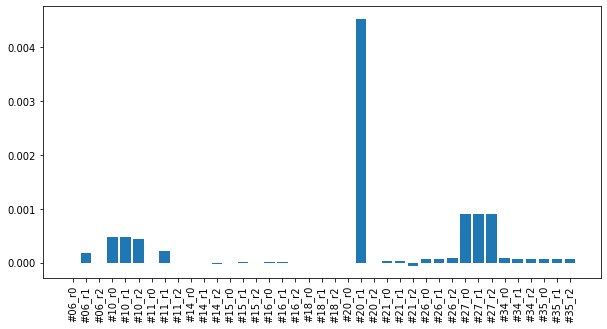

In [14]:
# In order to account for the un-equal cell counts at the beginning of the incubation period of each sample, the
# activity for each replicate is divided by the number of cell units within the original sample. 

for sample in activity_dict:
    sample_number = re.findall(r'^(?:#)(\d\d)', sample) # some RegEX for finding the sample number
    if len(sample_number)>0:
        sample_number = int(sample_number[0])
        activity_dict[sample] = activity_dict[sample]/OD_measures.loc[OD_measures['sample']==str(sample_number)].iloc[0]['cell_units']

print(activity_dict)

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(activity_dict.keys(), activity_dict.values())
plt.xticks(rotation=90)

# Step 5: Match the strain name with the strain, promoter, secretion peptide and gene combination

Once the activity of each sample has been determined, this activity needs to be matched to combination of parts used for creating the sample. The end result is a file in which can be directly used by the ART pipeline.  

In [25]:
os.chdir(cwd) # set the working directory back to the orignal one

results = pd.read_csv('Sample_list.csv', sep=',') # load in the file contianing the link of the sample name to the various parts
for sample in activity_dict:
    line_name, replicate = sample.split('_')
    
    # Adding the measured activity to the results
    results.loc[(results['Line name']==line_name) & (results['Replicate']==replicate), 'activity'] = activity_dict[sample]
    print(results.loc[(results['Line name']==line_name) & (results['Replicate']==replicate)])
# Write the results into the original file
results.to_csv('Sample_list.csv', sep=',', index=False) 

   Line name Replicate  activity  str_idx  pro_idx  sec_idx  gen_idx
15       #06        r0 -0.000001        2       11       17       19
   Line name Replicate  activity  str_idx  pro_idx  sec_idx  gen_idx
16       #06        r1  0.000177        2       11       17       19
   Line name Replicate activity  str_idx  pro_idx  sec_idx  gen_idx
17       #06        r2     -0.0        2       11       17       19
   Line name Replicate  activity  str_idx  pro_idx  sec_idx  gen_idx
27       #10        r0  0.000477        2        8       16       22
   Line name Replicate activity  str_idx  pro_idx  sec_idx  gen_idx
28       #10        r1  0.00048        2        8       16       22
   Line name Replicate  activity  str_idx  pro_idx  sec_idx  gen_idx
29       #10        r2  0.000439        2        8       16       22
   Line name Replicate  activity  str_idx  pro_idx  sec_idx  gen_idx
30       #11        r0  0.000003        2        5       15       21
   Line name Replicate  activity  str_

In [3]:
strains = pd.read_csv('mock_data.csv', sep=',')

print(strains.head())

#strains_art_oneh = strains.copy().loc[np.logical_or(strains['origin'] == 'lib', strains['origin'] == 'ctr')]

strains["Line Name"] = strains["Line Name"] + "-" + strains["Replicate Count"]

strains = strains.loc[:,['Line Name','measurement','str_idx', 'pro_idx', 'sec_idx', 'gen_idx']]
strains.head()

  Line Name Replicate Count  measurement  str_idx  pro_idx  sec_idx  gen_idx
0     SP001              r1     0.829131        2        6       16       22
1     SP001              r2     0.333064        2        6       16       22
2     SP001              r3     0.871142        2        6       16       22
3     SP002              r1     0.937158        4       11       18       19
4     SP002              r2     0.054991        4       11       18       19


,Line Name,measurement,str_idx,pro_idx,sec_idx,gen_idx
0,SP001-r1,0.829131,2,6,16,22
1,SP001-r2,0.333064,2,6,16,22
2,SP001-r3,0.871142,2,6,16,22
3,SP002-r1,0.937158,4,11,18,19
4,SP002-r2,0.054991,4,11,18,19


In [4]:
strains_art_oneh = pd.get_dummies(data=strains, columns=['str_idx', 'pro_idx', 'sec_idx', 'gen_idx'])
strains_art_oneh.head()

,Line Name,measurement,str_idx_1,str_idx_2,str_idx_3,str_idx_4,pro_idx_5,pro_idx_6,pro_idx_7,pro_idx_8,...,pro_idx_13,pro_idx_14,sec_idx_15,sec_idx_16,sec_idx_17,sec_idx_18,gen_idx_19,gen_idx_20,gen_idx_21,gen_idx_22
0,SP001-r1,0.829131,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,SP001-r2,0.333064,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,SP001-r3,0.871142,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,SP002-r1,0.937158,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,SP002-r2,0.054991,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [5]:
# store the columnnames as parameter setting for ART
colnames = strains_art_oneh.columns[2:].tolist()
print(colnames)

['str_idx_1', 'str_idx_2', 'str_idx_3', 'str_idx_4', 'pro_idx_5', 'pro_idx_6', 'pro_idx_7', 'pro_idx_8', 'pro_idx_11', 'pro_idx_13', 'pro_idx_14', 'sec_idx_15', 'sec_idx_16', 'sec_idx_17', 'sec_idx_18', 'gen_idx_19', 'gen_idx_20', 'gen_idx_21', 'gen_idx_22']


In [6]:
# Pivot the dataframe and change the column names
strains_art_oneh = strains_art_oneh.set_index('Line Name').stack().reset_index()
print(strains_art_oneh)
strains_art_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
strains_art_oneh.head()

     Line Name      level_1         0
0     SP001-r1  measurement  0.829131
1     SP001-r1    str_idx_1  0.000000
2     SP001-r1    str_idx_2  1.000000
3     SP001-r1    str_idx_3  0.000000
4     SP001-r1    str_idx_4  0.000000
...        ...          ...       ...
1135  SP019-r3   sec_idx_18  0.000000
1136  SP019-r3   gen_idx_19  0.000000
1137  SP019-r3   gen_idx_20  0.000000
1138  SP019-r3   gen_idx_21  1.000000
1139  SP019-r3   gen_idx_22  0.000000

[1140 rows x 3 columns]


,Line Name,Measurement Type,Value
0,SP001-r1,measurement,0.829131
1,SP001-r1,str_idx_1,0.000000
2,SP001-r1,str_idx_2,1.000000
3,SP001-r1,str_idx_3,0.000000
4,SP001-r1,str_idx_4,0.000000


# This section will be handling noice detection and elimination. While we are still handling mock data, it can be disregarded.

In [7]:
measurement = ['measurement']

In [8]:
noisy_line_name = utils.find_noisy_data(strains_art_oneh, measurement, percentile=99,plot_flag=False)
strains_art_oneh_filtered = utils.filter_noisy_data(strains_art_oneh, noisy_line_name, measurement, filter_all_replicates=True,plot_flag=False)


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


,Value,Measurement Type,Replicate Mean,Replicate Error
Line Name,,,,
SP002-r1,0.937158,measurement,0.387615,0.549542


,Line Name,Measurement Type,Value
60,SP002-r1,measurement,0.937158
80,SP002-r2,measurement,0.054991
100,SP002-r3,measurement,0.170698


In [9]:
errors = utils.add_replicate_mean_and_error(strains_art_oneh, ['measurement'])['Replicate Error']
limit = round(np.percentile(abs(errors), 99),2)
print("The value that delimites the one percent most extreme errors is: {}".format(limit))

The value that delimites the one percent most extreme errors is: 0.5


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


In [10]:
errors.abs().mean()*2.5

0.49033361243682116

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


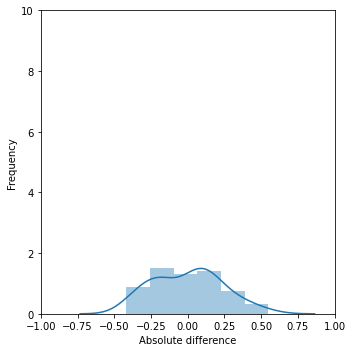

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax);
ax.set_ylim(0, 10)
ax.set_xlim(-1, 1)
ax.set_ylabel('Frequency')
ax.set_xlabel('Absolute difference')
fig.savefig('./figures/Figure 4B.pdf')

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


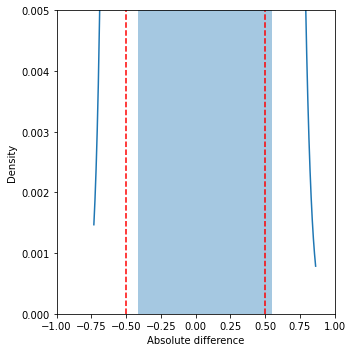

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax)
ax.set_ylim(0, 0.005)
ax.set_xlim(-130, 130)
ax.axvline(x=limit, ymin=0, color='r', ls='--')
ax.axvline(x=-limit, ymin=0, color='r', ls='--')
ax.annotate(str(round(-limit, 2)), xy=(-limit-50, 0), xytext=(-limit-50, 0.002), color='r')
ax.annotate(str(round(limit, 2)), xy=(limit+5, 0), xytext=(limit+5, 0.002), color='r')
ax.set_xlabel('Absolute difference')
fig.savefig('./figures/Figure 4C.pdf')

# RUNNING ART!!!!!

In [11]:
art_params = {}
art_params['response_vars'] = measurement
art_params['input_vars'] = colnames
art_params['seed'] = 42  # default: None
art_params['num_recommendations'] = 30   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = 'results_onehot/'


In [12]:
run_art = False

In [13]:
%%time
if run_art:
    art = RecommendationEngine(strains_art_oneh, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

CPU times: user 131 ms, sys: 118 ms, total: 249 ms
Wall time: 6.84 s


## Starting with analysis of the data

In [14]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,1.104182,584.258551,1.940910,4.986350,-58.992243
Random Forest Regressor,0.249611,280.704693,0.170122,0.091247,-0.097824
TPOT Regressor,0.259209,278.552805,0.171459,0.096587,-0.162072
Support Vector Regressor,0.251958,269.026522,0.152847,0.086845,-0.044856
Kernel Ridge Regressor,0.402462,109.105827,0.259633,0.229385,-1.759797
K-NN Regressor,0.243453,280.314682,0.174101,0.089581,-0.077770
Gaussian Process Regressor,0.253649,265.143738,0.144137,0.085113,-0.024020
Gradient Boosting Regressor,0.243457,271.920112,0.167972,0.087486,-0.052568
Ensemble Model,0.253090,269.600868,0.160006,0.089656,-0.078682


Crossvalidated ensemble prediction compared to observations of mean productivity of library and control strains


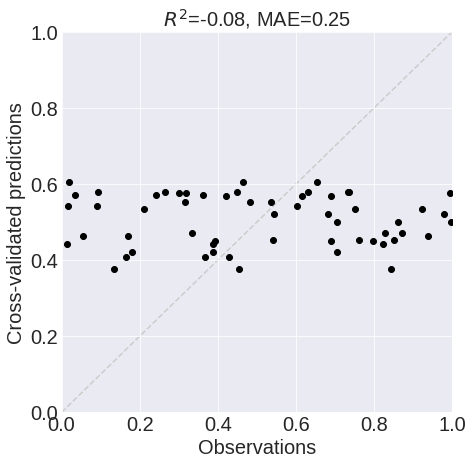

In [14]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=False, xlim=[[0, 1]], ylim=[[0, 1]], log=False)

Ensemble prediction compared to observations of mean productivity of library and control strains


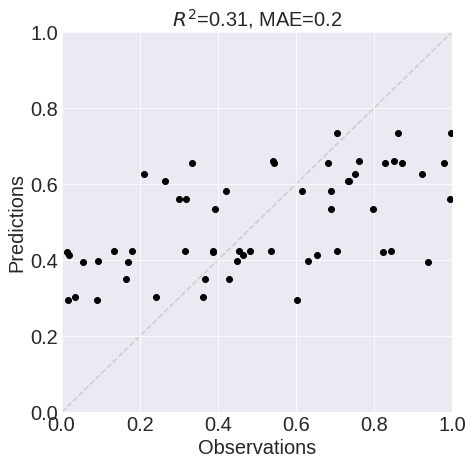

In [16]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=False, xlim=[[0, 1]], ylim=[[0, 1]], log=False)

### learning curves

10 cross-validation runs were performed in parallel running the script `learning_curves_per_set_size.py` with arguments `run_number` and `set_index` (between 0 and 14 for a total of 15 cases). The results were stored in

## TODO:
Adapt the `learning_curves_per_set_size.py` such that it is applicable to our dataset (see Zang and Petersen et al. (2019)).

In [17]:
output_directory = './results_onehot/learning_curves'

In [ ]:
num_runs = 10
metrics_all = {}
for run in range(num_runs):
    filename = f'{output_directory}/metrics_train_test_{run+1}.pkl'
    with open(filename, 'rb') as f:
        metrics_all[run] = pickle.load(f) 

### Adding predictions to main dataframe

In [40]:
cv_prediction      = np.array(art.model_df_cv[0]['Predictions']['Ensemble Model'])
predicted_mean, predicted_std = art.post_pred_stats(art.load_input_data(scale=False))
jbei_library_pred_df = pd.DataFrame({'Line Name' : strains_art_oneh_filtered['Line Name'].unique(),'prediction_JBEI' : predicted_mean.squeeze(), 'cv_prediction_JBEI' : cv_prediction})
jbei_library_pred_df['Line Name'], jbei_library_pred_df['replicate_count'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str
print(jbei_library_pred_df)
# jbei_library_pred_df.head()

   Line Name  prediction_JBEI  cv_prediction_JBEI Replicate Count
0      SP001         0.654151            0.471133              r1
1      SP001         0.654151            0.471133              r2
2      SP001         0.654151            0.471133              r3
3      SP002         0.393837            0.463324              r1
4      SP002         0.393837            0.463324              r2
5      SP002         0.393837            0.463324              r3
6      SP003         0.421236            0.441021              r1
7      SP003         0.421236            0.441021              r2
8      SP003         0.421236            0.441021              r3
9      SP004         0.422982            0.376040              r1
10     SP004         0.422982            0.376040              r2
11     SP004         0.422982            0.376040              r3
12     SP005         0.560198            0.576586              r1
13     SP005         0.560198            0.576586              r2
14     SP0

/tmp/ipykernel_35490/527757656.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  jbei_library_pred_df['Line Name'], jbei_library_pred_df['Replicate Count'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str


In [47]:

print(jbei_library_pred_df.head())
strains = pd.read_csv('mock_data.csv', sep=',')
print(strains.head())

strains = pd.merge(strains, jbei_library_pred_df,  how='left', left_on=['Line Name', 'replicate_count'], right_on = ['Line Name', 'replicate_count'])
strains.head()

  Line Name  prediction_JBEI  cv_prediction_JBEI Replicate Count
0     SP001         0.654151            0.471133              r1
1     SP001         0.654151            0.471133              r2
2     SP001         0.654151            0.471133              r3
3     SP002         0.393837            0.463324              r1
4     SP002         0.393837            0.463324              r2
  Line Name Replicate Count  measurement  str_idx  pro_idx  sec_idx  gen_idx
0     SP001              r1     0.829131        2        6       16       22
1     SP001              r2     0.333064        2        6       16       22
2     SP001              r3     0.871142        2        6       16       22
3     SP002              r1     0.937158        4       11       18       19
4     SP002              r2     0.054991        4       11       18       19


,Line Name,Replicate Count,measurement,str_idx,pro_idx,sec_idx,gen_idx,prediction_JBEI,cv_prediction_JBEI
0,SP001,r1,0.829131,2,6,16,22,0.654151,0.471133
1,SP001,r2,0.333064,2,6,16,22,0.654151,0.471133
2,SP001,r3,0.871142,2,6,16,22,0.654151,0.471133
3,SP002,r1,0.937158,4,11,18,19,0.393837,0.463324
4,SP002,r2,0.054991,4,11,18,19,0.393837,0.463324


In [ ]:
num_strains = 4
indeces_strains = np.array(range(1,num_strains+1))
num_promoters = 10
indeces_promoters = np.array(range(num_strains+1, num_strains+num_promoters+1))
num_secretion_signals = 4
indeces_secretion = np.array(range(num_strains+num_promoters+1, num_strains+num_promoters+num_secretion_signals+1))
num_genes = 4

In [57]:
num_of_promoters = 6
num_of_genes = 5
num_of_designs = 4*7*4*4
num_of_promoters_onehot = art.num_input_var
designs = np.zeros((num_of_designs, num_of_promoters_onehot))

i = 0

promoters = np.eye(7)
seqretion = np.eye(4)

for p1 in seqretion:
    for p2 in promoters:
        for p3 in seqretion:
            for p4 in seqretion:
                designs[i,:] = np.hstack((p1,p2,p3,p4)).astype(int)
                i+=1

print(designs[:5])


[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]]


Calculate mean predicted production and standard deviation for all possible designs.

In [59]:
pp_mean, pp_std = art.post_pred_stats(designs)

The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [58]:
art.rel_eng_accuracy = 0.01

### Exploitative approach

Objective function is defined as the mean predicted production (the parameter for exploration is set to 𝛼=0
).

In [61]:
obj_func = pp_mean 
data = np.hstack((designs, obj_func, obj_func))
print(data)

[[1.         0.         0.         ... 0.         0.44887904 0.44887904]
 [1.         0.         0.         ... 0.         0.54857018 0.54857018]
 [1.         0.         0.         ... 0.         0.5868449  0.5868449 ]
 ...
 [0.         0.         0.         ... 0.         0.46325537 0.46325537]
 [0.         0.         0.         ... 0.         0.45935323 0.45935323]
 [0.         0.         0.         ... 1.         0.42411605 0.42411605]]


In [62]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

Mean and standard deviation of the recommendation with the highest predicted production are: 0.70, 0.30


../ART_iGEM/art/core.py:1610: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])
../ART_iGEM/art/core.py:1610: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])


In [66]:
df_rec_categ_exploit = pd.DataFrame(index=art.recommendations.index, columns=['strain','promoter','seqretion','gene',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][art.recommendations.values[i,:] > 0]
    df_rec_categ_exploit.iloc[i][('strain','promoter','seqretion','gene')] = [int(float(p.split('_')[2])) for p in rec.index[:-1]]
    df_rec_categ_exploit.iloc[i][measurement] = rec[measurement]
df_rec_categ_exploit.head()

str_idx_3      1.000000
pro_idx_7      1.000000
sec_idx_15     1.000000
gen_idx_22     1.000000
measurement    0.701008
Name: 0, dtype: float64
str_idx_2      1.000000
pro_idx_7      1.000000
sec_idx_15     1.000000
gen_idx_21     1.000000
measurement    0.683987
Name: 1, dtype: float64
str_idx_3      1.000000
pro_idx_7      1.000000
sec_idx_16     1.000000
gen_idx_21     1.000000
measurement    0.682584
Name: 2, dtype: float64
str_idx_1      1.000000
pro_idx_7      1.000000
sec_idx_15     1.000000
gen_idx_21     1.000000
measurement    0.675854
Name: 3, dtype: float64
str_idx_3      1.000000
pro_idx_8      1.000000
sec_idx_15     1.000000
gen_idx_21     1.000000
measurement    0.665815
Name: 4, dtype: float64
str_idx_2      1.000000
pro_idx_7      1.000000
sec_idx_15     1.000000
gen_idx_22     1.000000
measurement    0.654832
Name: 5, dtype: float64
str_idx_1      1.000000
pro_idx_7      1.000000
sec_idx_15     1.000000
gen_idx_22     1.000000
measurement    0.652208
Name: 6, dtype: 

,strain,promoter,seqretion,gene,measurement
0,3,7,15,22,0.701008
1,2,7,15,21,0.683987
2,3,7,16,21,0.682584
3,1,7,15,21,0.675854
4,3,8,15,21,0.665815


In [67]:
df_rec_categ_exploit.nunique()

strain          3
promoter        5
seqretion       3
gene            3
measurement    30
dtype: int64